#  Прогнозирование заказов такси

**Описание проекта и цель исследования:**

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.


Критерии, которые важны заказчику:
* значение метрики `RMSE` на тестовой выборке должно быть не больше 48.

**Ход исследования:**

* загрузка данных;
* предобработка данных;
* исследовательский анализ данных;
* обучение моделей и получение предсказаний;
* оформление выводов

**Признаковое описание данных:**

* `datetime` — дата и время, описывающее количество заказов такси за интервал времени

**Целевой признак:**
* `num_orders` — количество заказов

**Файлы с данными:**
* `/datasets/taxi.csv`

## Загрузка данных

In [1]:
#импортируем необходимые библиотеки
!pip install --upgrade -q scikit-learn


import copy
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
#ограничим выдачу предупреждений
warnings.filterwarnings("ignore")

In [3]:
#настроим отображение графиков и столбцов
plt.rcParams['figure.figsize'] = (15, 10)
pd.set_option('display.max_columns', None)

In [4]:
#считываем файл
pth1_1 = '/datasets/taxi.csv'
pth1_2 = 'taxi.csv'

if os.path.exists(pth1_1):
    taxi = pd.read_csv(pth1_1)
elif os.path.exists(pth1_2):
    taxi = pd.read_csv(pth1_2)
else:
    print('Something is wrong with file taxi.csv')

In [5]:
#посмотрим на данные в файле taxi
taxi.head(20)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


Необходимые библиотеки импортированы, данные загружены, названия столбцов соответствуют змеиному регистру.

## Предобработка данных

In [6]:
#функция, возвращающая базовую информацию о датафрейме
def df_basic_info(df):
    #df - датафрейм
    
    print(f'Названия столбцов\n\n{df.columns}')
    print('----------------------------------------------------------------')
    print('Основные параметры данных\n\n')
    df.info()
    print('----------------------------------------------------------------')
    print(f'Число уникальных значений признаков\n\n{df.nunique()}')
    print('----------------------------------------------------------------')
    print(f'Типы данных\n\n{df.dtypes.value_counts()}')
    print('----------------------------------------------------------------')
    print(f'Размер датафрейма\n\n{df.shape}')
    print('----------------------------------------------------------------')
    print(f'Базовые статистики\n\n{df.describe()}')
    print('----------------------------------------------------------------')
    print(f'Доля пропущенных значений\n\n{df.isna().mean().sort_values()}')
    print('----------------------------------------------------------------')
    print(f'Количество полных дубликатов\n\n{df.duplicated().sum()}')
    print('----------------------------------------------------------------')
    return df.head(10)

In [7]:
#получим базовое представление о данных
df_basic_info(taxi)

Названия столбцов

Index(['datetime', 'num_orders'], dtype='object')
----------------------------------------------------------------
Основные параметры данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
----------------------------------------------------------------
Число уникальных значений признаков

datetime      26496
num_orders       81
dtype: int64
----------------------------------------------------------------
Типы данных

int64     1
object    1
dtype: int64
----------------------------------------------------------------
Размер датафрейма

(26496, 2)
----------------------------------------------------------------
Базовые статистики

         num_orders
count  26496.000000
mean      14.070463
std     

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


Пропущенных значений и полных дубликатов в данных не наблюдается. Изменим тип данных в столбце `datetime` на правильный

In [8]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'], format='%Y-%m-%d %H:%M:%S')

Если посмотреть на базовые статистики числа заказов, то можно отметить, что среднее и медиана близки, при этом максимальное значение достаточно высокое. Более подробно изучим данные в разделе с EDA.

Проведём индексацию данных на основе столбца `datetime`

In [9]:
taxi.set_index('datetime', inplace=True)
taxi.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Переиндексация произведена успешно. Проведём проверку монотонности индекса

In [10]:
taxi.index.is_monotonic

True

Индекс монотонный, что хорошо.

Таким образом, в данном разделе проведена базовая предобработка данных. Отмечено отсутствие пропущенных значений и полных дубликатов. Проведена переиндексация датафрейма на основе признака `datetime`, для которого предварительно изменён тип данных на `datetime64`. Полученный индекс нарастает монотонно. Анализ базовых статистик признака `num_orders` не выявил аномалий, более подробно данные будут изучены в следующем разделе.

## EDA

In [11]:
#функция для анализа количественных признаков
def quant_feat_analysis(df, feat, df_name):
    #df - датафрейм
    #feat - количественный признак
    #df_name - название датафрейма
    
    print(f'Базовые статистики\n\n{df[feat].describe()}')
    print('-----------------------------------------------------')
    fig, (ax_box, ax_hist) = plt.subplots(2,
                                          sharex=True,
                                          gridspec_kw = {'height_ratios': (.1, .9)})
    #отрисовка боксплота
    sns.boxplot(data=df, 
                x=feat,
                color='cadetblue',
                ax=ax_box)
    
    #отрисовка гистограммы
    sns.histplot(data=df,
                 x=feat,
                 bins=round(1 + np.log2(df.shape[0])),
                 kde=True,
                 color='cadetblue',
                 ax=ax_hist)
    
    ax_box.set(xlabel = '') 
    ax_box.set(title=f'Распределение признака {feat}\n в датафрейме {df_name}') 
    ax_hist.set(xlabel=feat)
    ax_hist.set(ylabel='Количество временных отрезков')
    
    plt.show()

Изучим распределение таргета

Базовые статистики

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64
-----------------------------------------------------


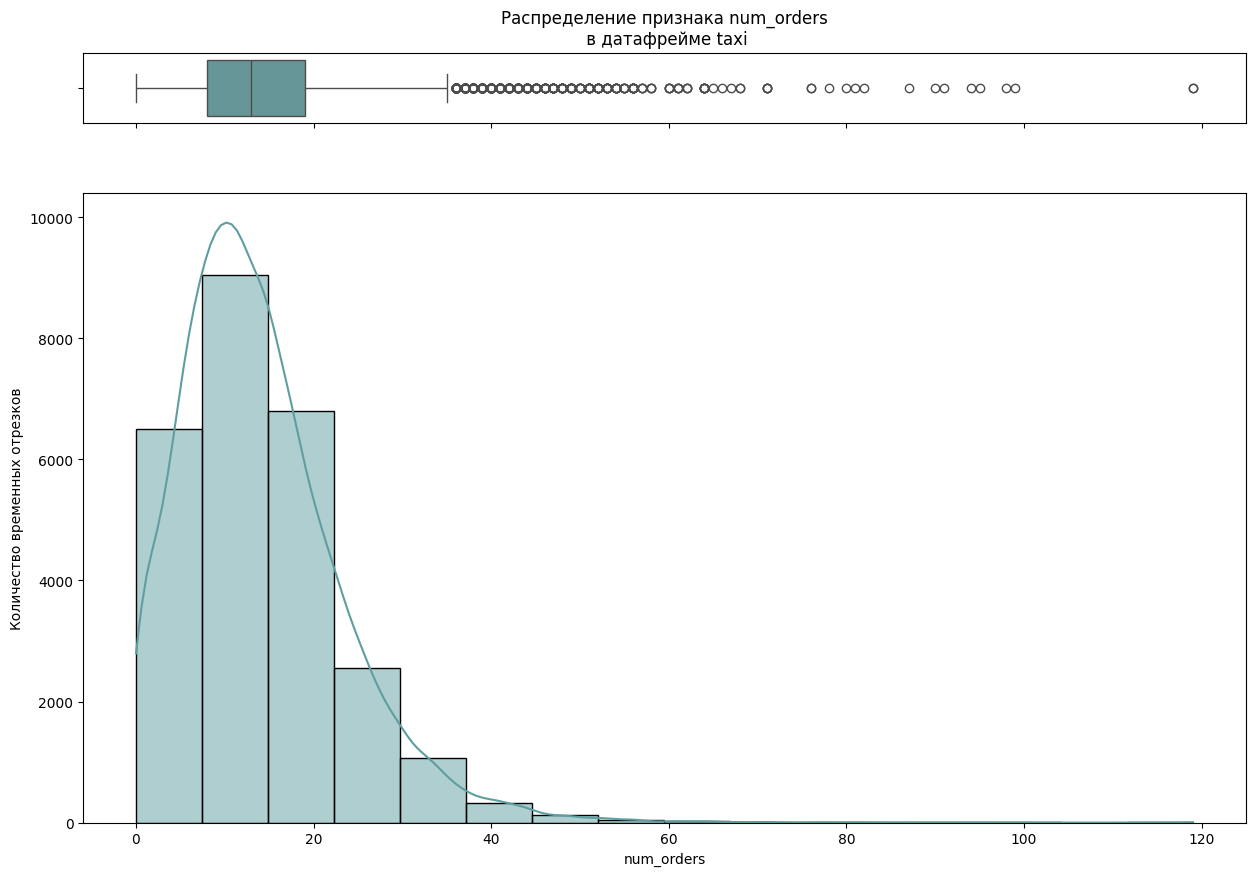

In [12]:
quant_feat_analysis(taxi, 'num_orders', 'taxi')

Наблюдаем распределение Пуассона - присутствует хвост из дней с большим числом заказов такси; среднее больше медианы. Наша модель должна будет уметь предсказывать данные значения

Наконец, посмотрим на данные

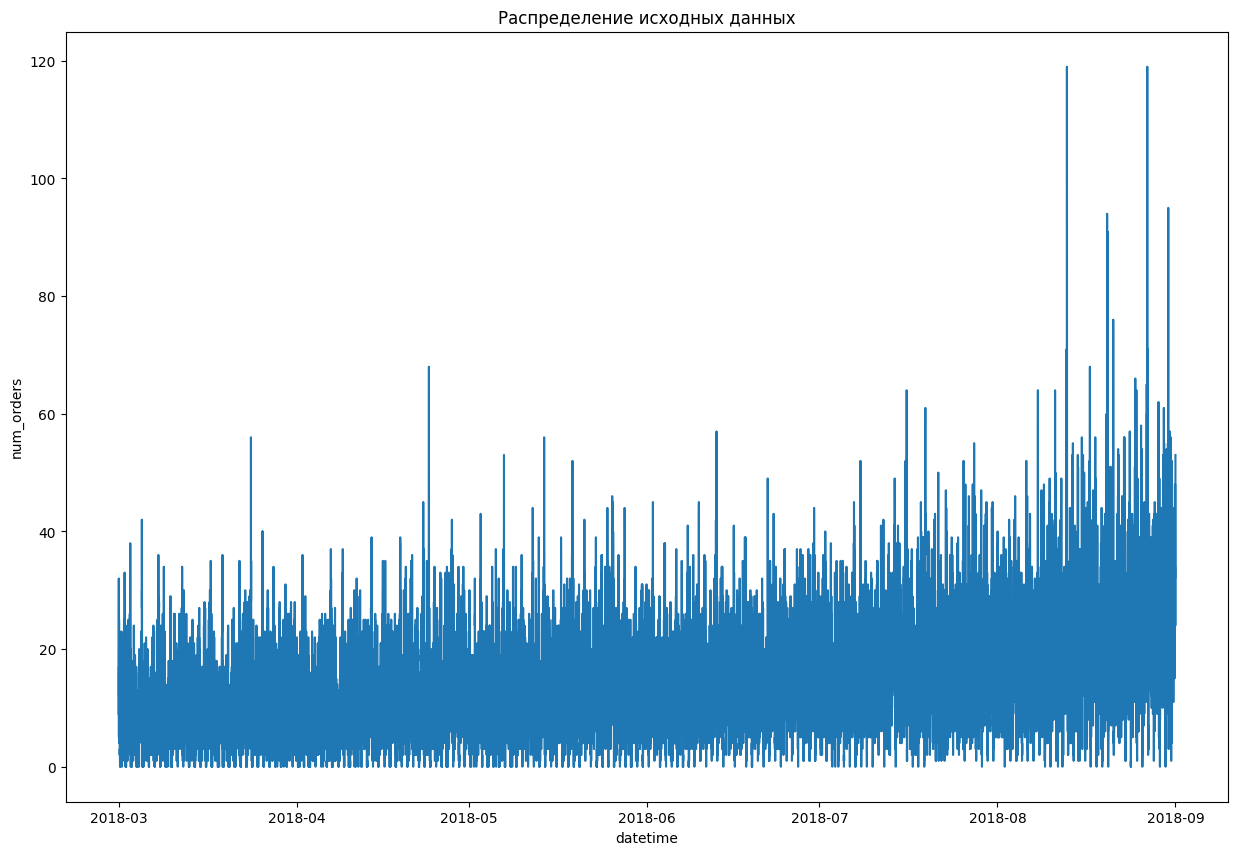

In [13]:
sns.lineplot(data=taxi,
             x=taxi.index,
             y='num_orders').set(title='Распределение исходных данных');

Мало что понятно. Сделаем ресэмплирование данных по одному часу через суммирование десятиминутных отрезков, как отмечено в условии

In [14]:
taxi = taxi.resample('1H').sum()
taxi.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Базовые статистики

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64
-----------------------------------------------------


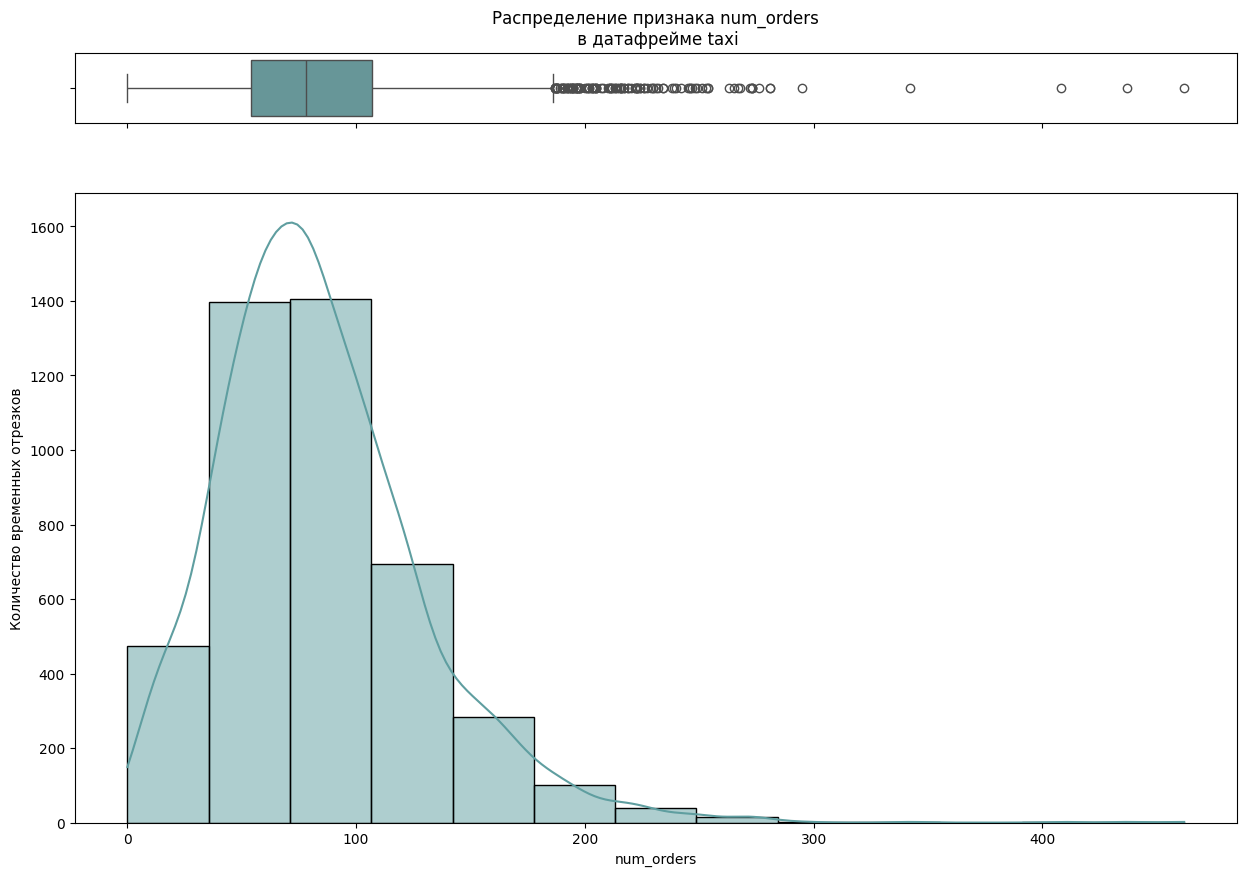

In [15]:
#посмотрим на обновлённые данные
quant_feat_analysis(taxi, 'num_orders', 'taxi')

Вид распределения таргета и тенденции мало изменились, наблюдаем всё то же распределение Пуассона

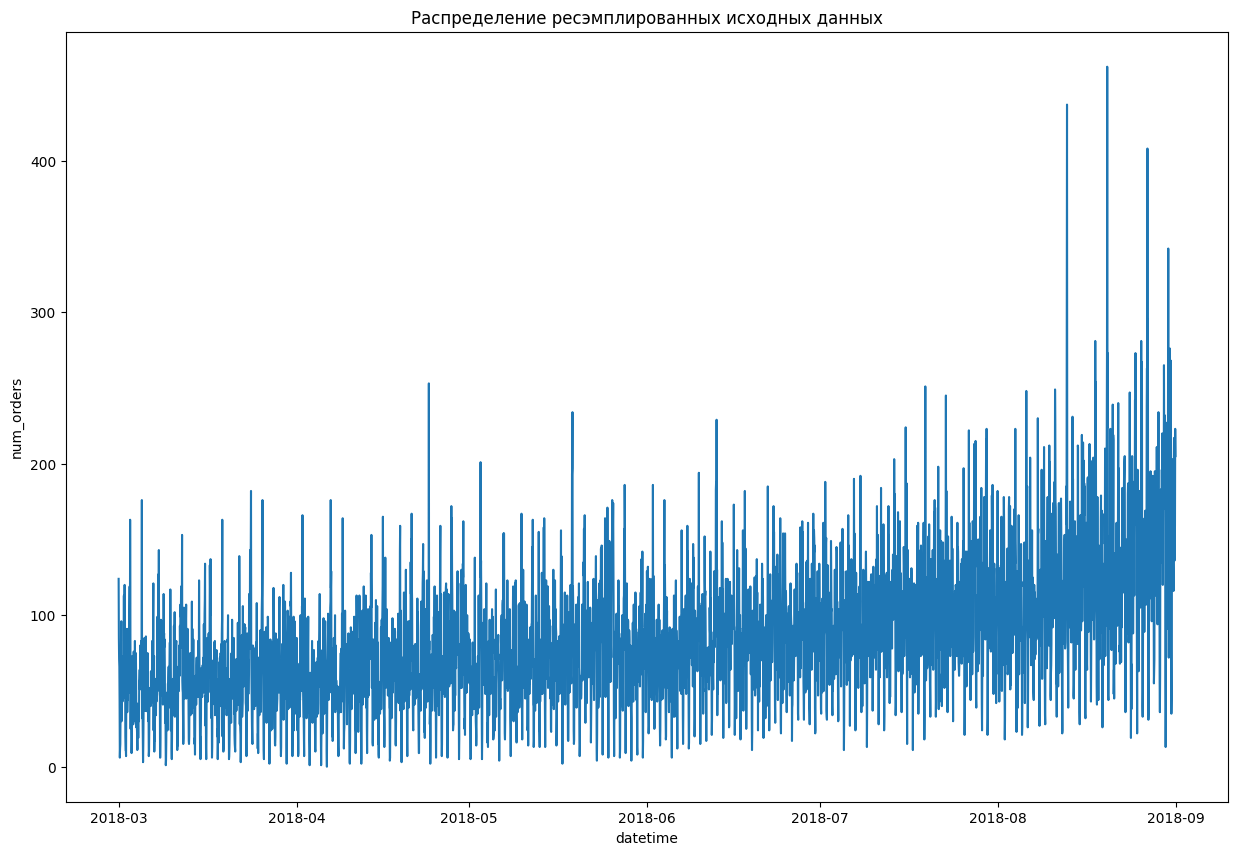

In [16]:
sns.lineplot(data=taxi,
             x=taxi.index,
             y='num_orders').set(title='Распределение ресэмплированных исходных данных');

Визуально можно отметить наличие тренда, однако необходимо более точно исследовать данные

Создадим копию ресэмплированных данных

In [17]:
taxi_copy = copy.deepcopy(taxi)

Посмотрим на разложение нашего временного ряда на составляющие

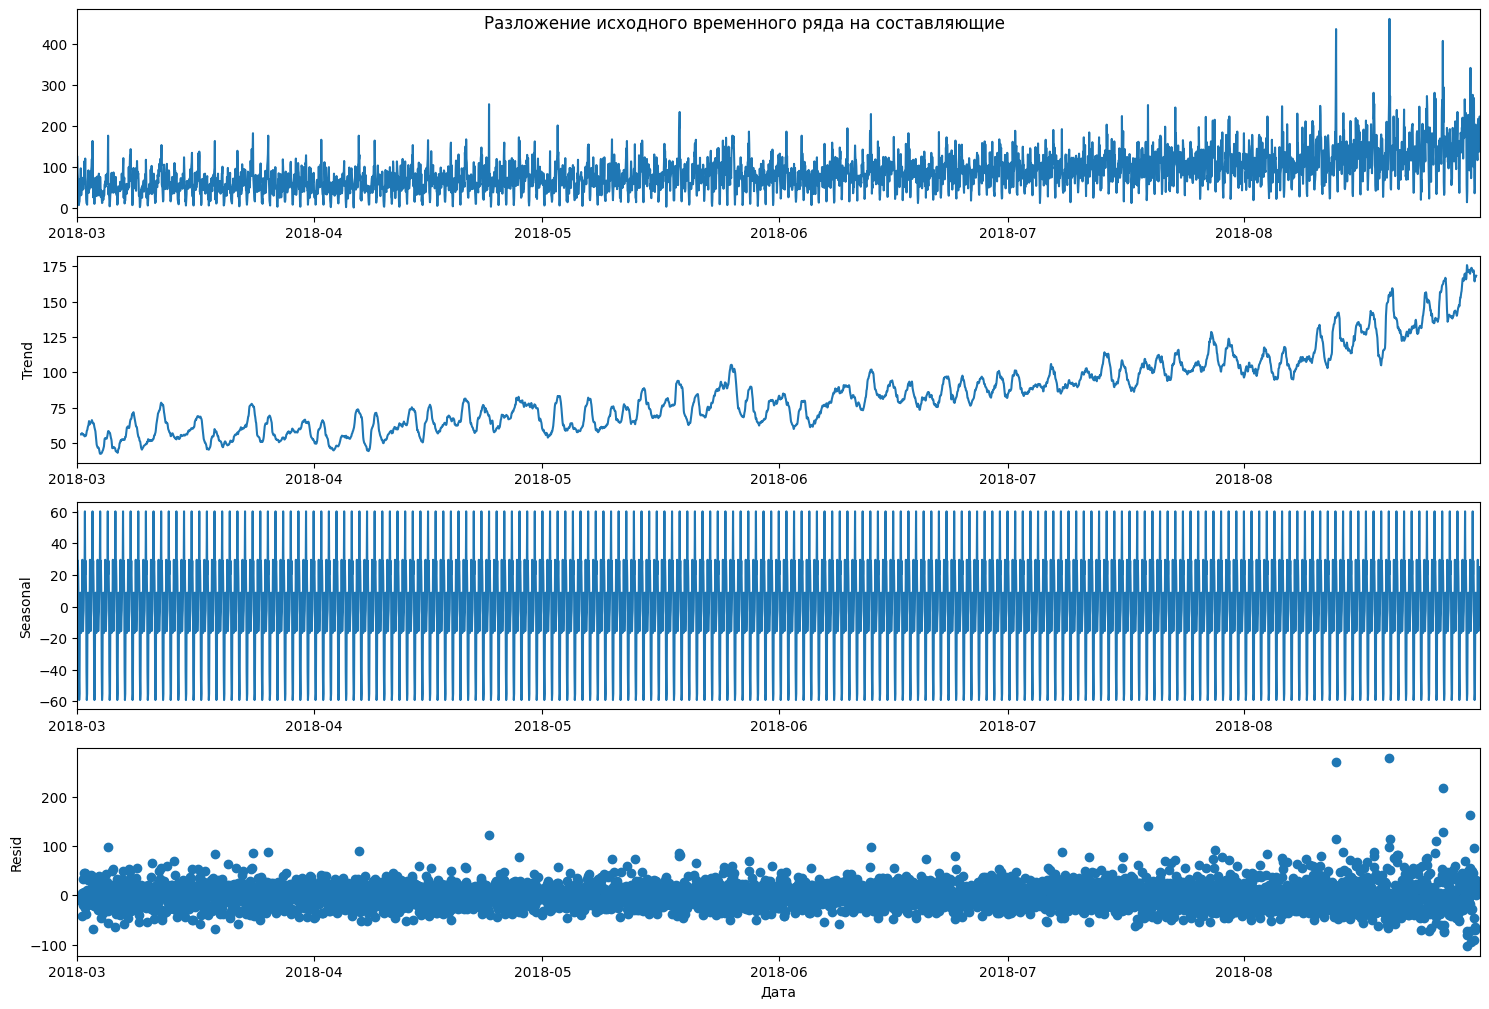

In [18]:
decompose = seasonal_decompose(taxi)
decompose.plot()
plt.xlabel('Дата')
plt.suptitle('Разложение исходного временного ряда на составляющие')
plt.show()

Явно видно наличие тренда и, судя по всему, сезонности, с которой надо разобраться подробнее

Сначала посмотрим, как можно избавиться от тренда

Посмотрим на распределение остатков по месяцам c помощью боксплота

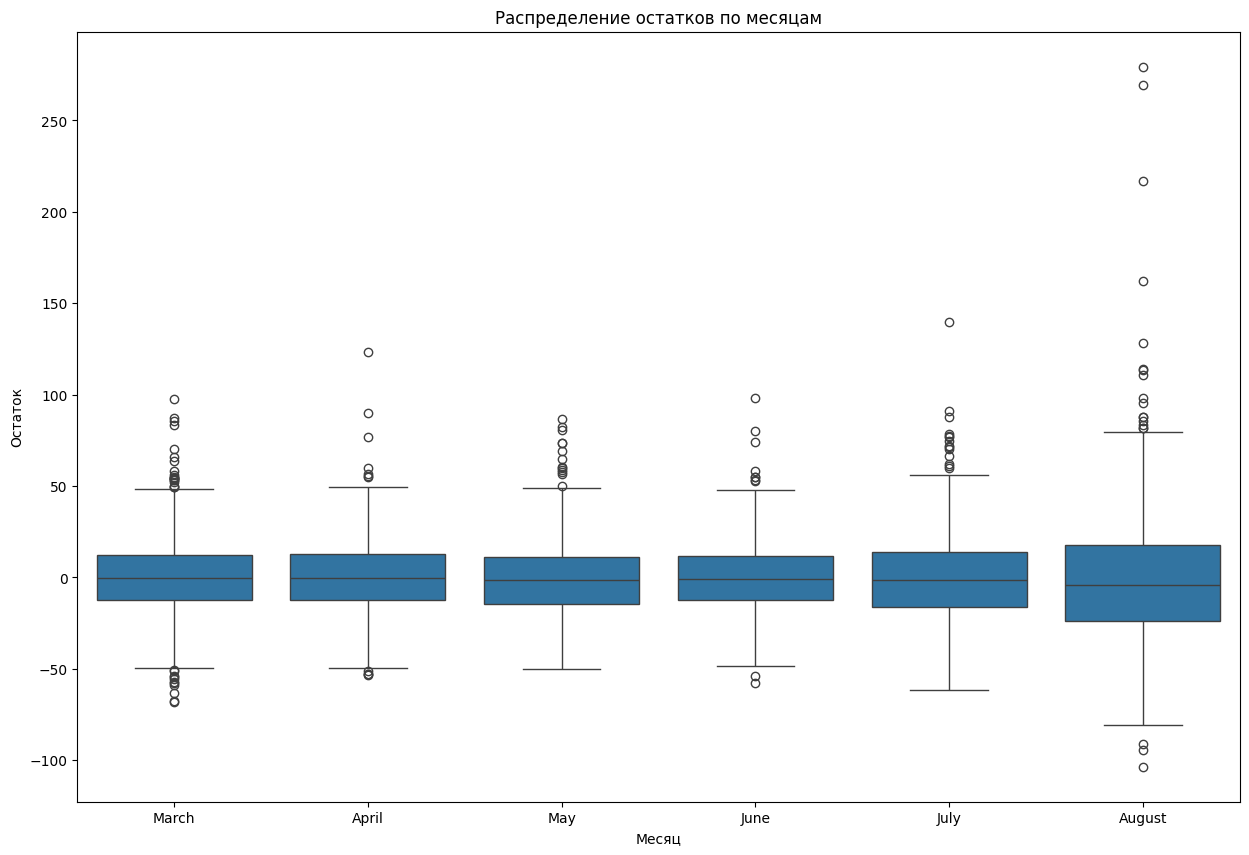

In [19]:
#отдельно создадим датафрейм с остатками
resids = decompose.resid

df_resid = resids.to_frame(name='resid')
df_resid['month'] = df_resid.index.month_name()  

plt.figure()
sns.boxplot(data=df_resid, 
            x='month', 
            y='resid', 
            order=df_resid['month'].unique()
)

plt.xlabel('Месяц')
plt.ylabel('Остаток')
plt.title("Распределение остатков по месяцам")
plt.show()

На боксплоте видно, что, начиная с июля, доля остатков возрастает (видно как по межквартильному интервалу, так и по "усам", и
по выбросам). Это может говорить нам о том, что непредсказываемая/шумовая часть значений таргета возрастает с течением времени, соответственно, нас может ожидать некоторое снижение качества предсказаний модели на тесте в сравнении с предсказаниями на тренировочных данных

Попробуем понять теперь, как можно устранить тренд

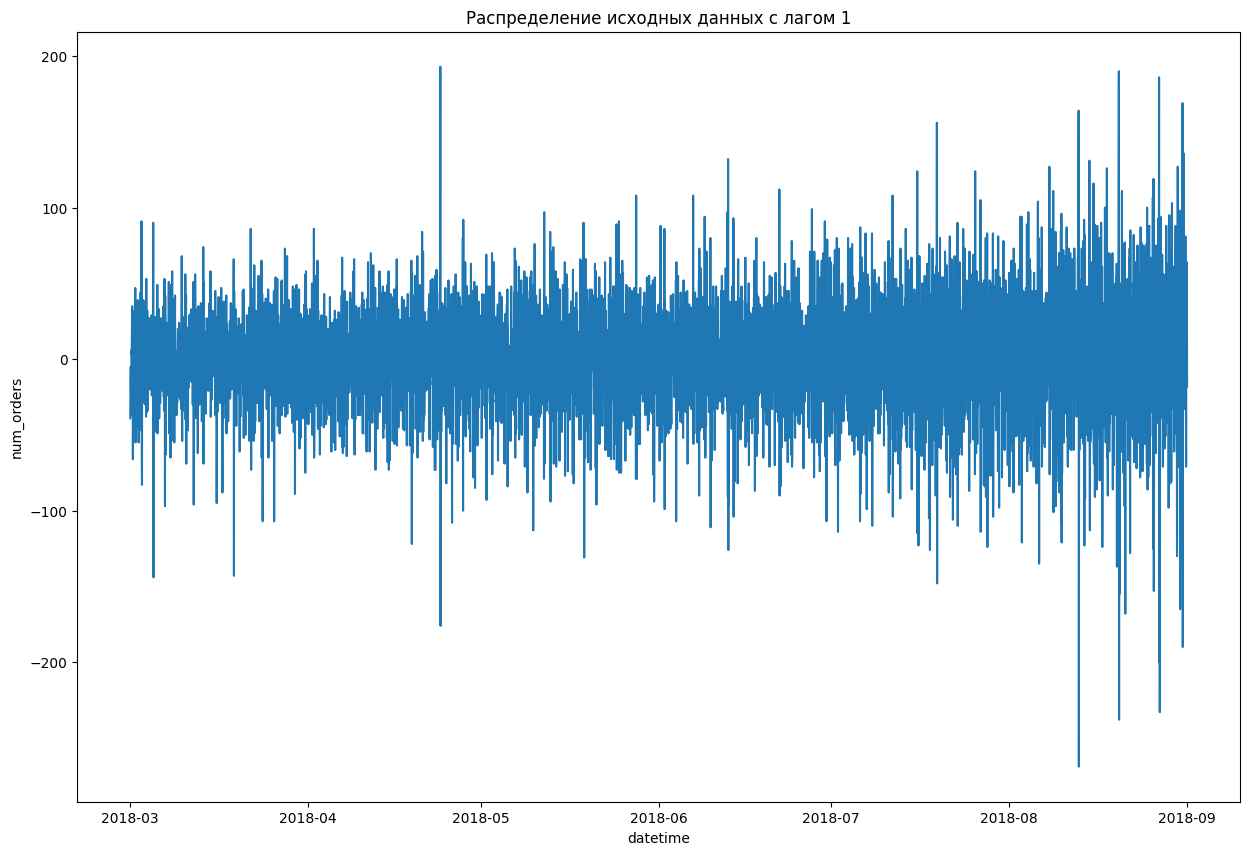

In [20]:
sns.lineplot(data=taxi.diff(1),
             x=taxi.index,
             y='num_orders').set(title='Распределение исходных данных c лагом 1');

Видно, что лаг, равный 1, устраняет тренд

Теперь попробуем разобраться с сезонностью c помощью `plot_acf` - графика автокорреляционной функции. Установим параметр `lags`, равный 200 - попробуем определить как суточную, так и недельную сезонность

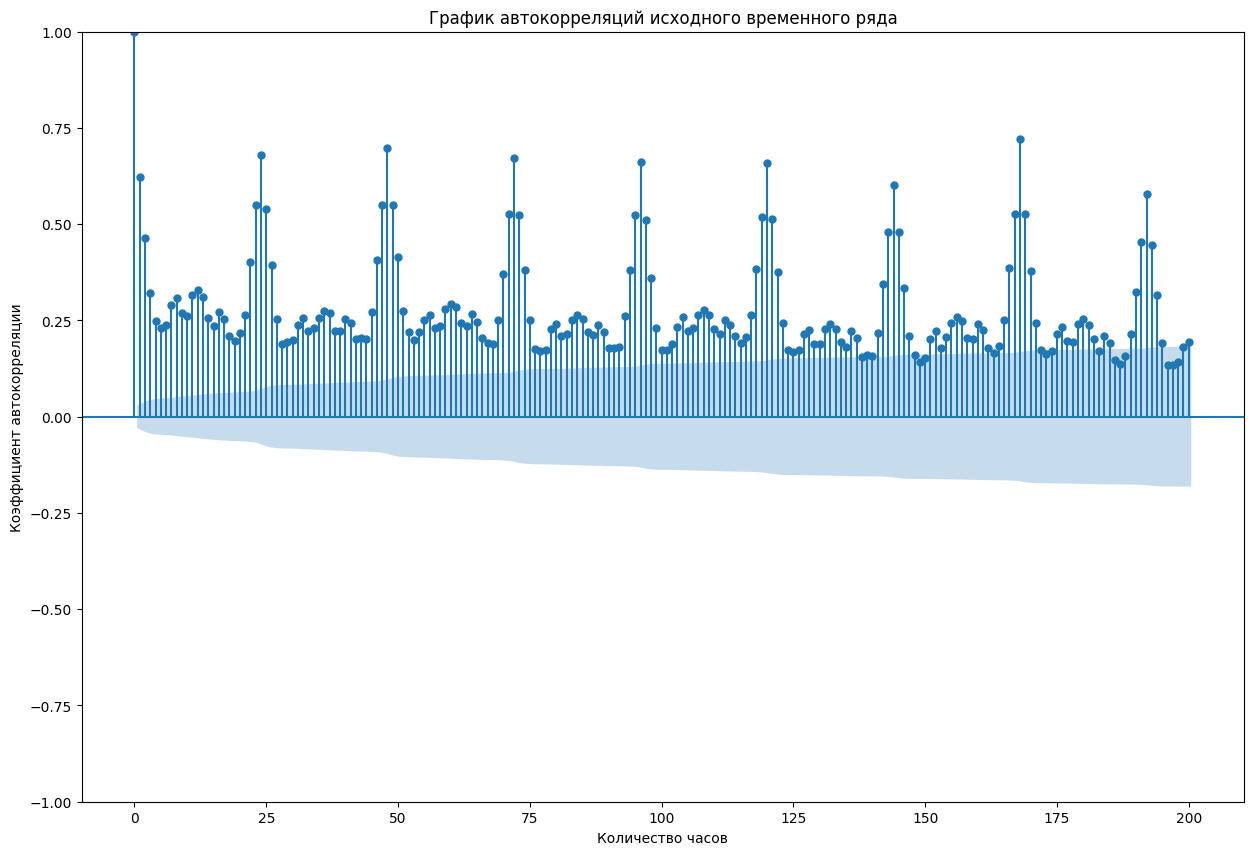

In [21]:
plot_acf(taxi, lags=200)
plt.xlabel('Количество часов')
plt.ylabel('Коэффициент автокорреляции')
plt.title('График автокорреляций исходного временного ряда')
plt.show()

Отчётливо заметна, во-первых, суточная сезонность (автокорреляция лагов 24, 48 и тд значимо больше автокорреляции соседних лагов с текущим значением), во-вторых, недельная сезонность (автокорреляция лага 168 значимо больше автокорреляции соседних суточных лагов с текущим значением)

Посмотрим также на графики со скользящим средним c разным значением окна. Для наглядности возьмём двухнедельный интервал наблюдений и окна со значениями 24 и 168

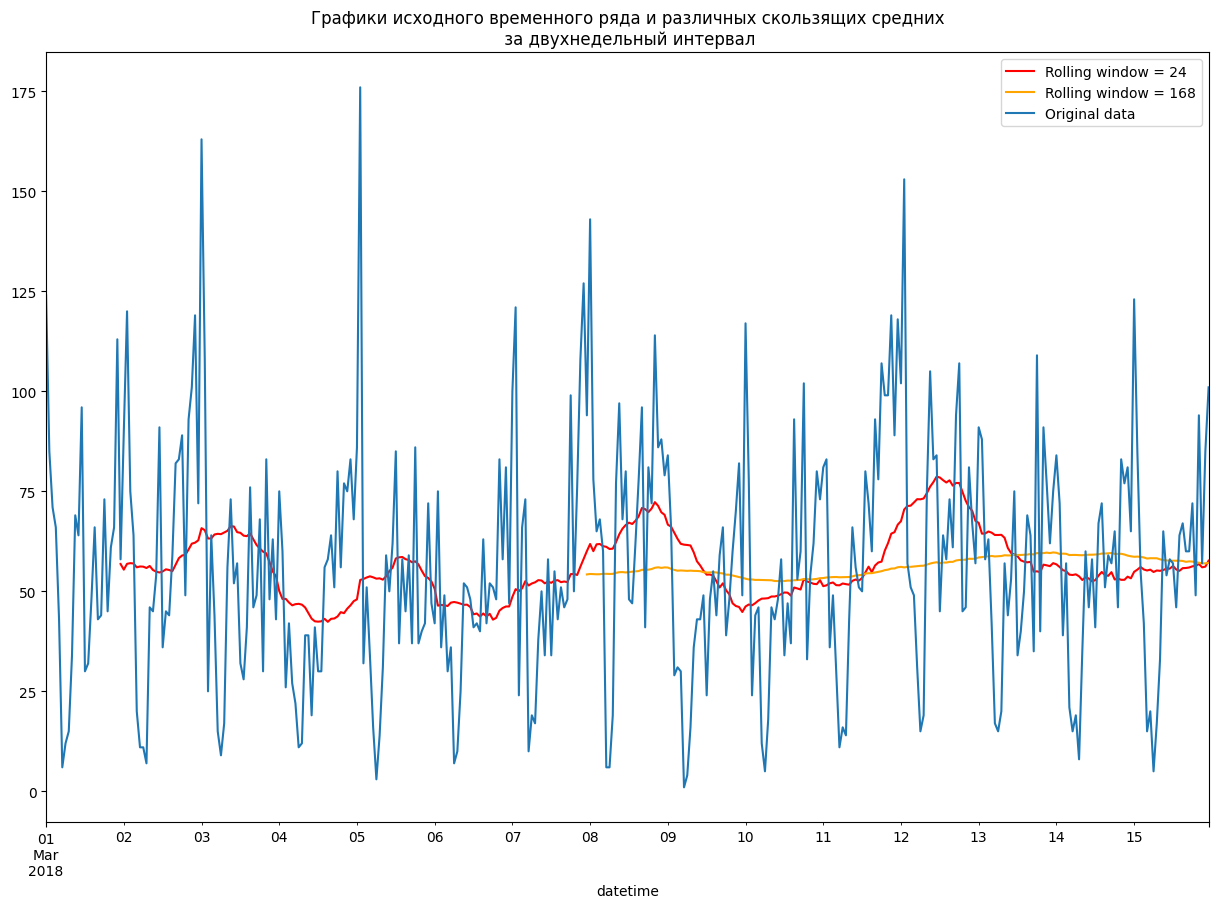

In [22]:
fig, ax = plt.subplots()

taxi['2018-03-01':'2018-03-15'].rolling(window=24).mean().plot(c='red', ax=ax)
taxi['2018-03-01':'2018-03-15'].rolling(window=168).mean().plot(c='orange', ax=ax)

taxi['2018-03-01':'2018-03-15'].plot(label='Original', ax=ax)

ax.legend(['Rolling window = 24', 'Rolling window = 168', 'Original data'])
ax.set_title('Графики исходного временного ряда и различных скользящих средних\n за двухнедельный интервал');

Отчётливо видно, что использование окна со значением 24 (суточная сезонность) и особенно 168 (недельная сезонность) приводит к сильному сглаживанию кривой 

Наконец, проверим, является ли наш ряд стационарным. Используем пороговое значение, равное 0.05

In [23]:
adf_test = adfuller(taxi['num_orders'])
 
# выведем p-value 
print('p-value = ' + str(adf_test[1]))

p-value = 0.028940051402613094


Судя по тесту Дики-Фуллера, можно отвергнуть нулевую гипотезу, что ряд нестационарный

Таким образом, в данном разделе провели исследовательский анализ данных:

* проведено ресэмплирование исходных данных по одному часу;
* по тесту Дики-Фуллера можно отвергнуть нулевую гипотезу, что наш исходный ряд является нестационарным;
* установлено, что в нашем ряду присутствует тренд, устраняемый лагом 1;
* установлено, что в нашем ряду присутствует суточная и недельная сезонность;
* отмечено, что использование скользящего среднего с окнами, равными 24 и 168 - суточная и недельная сезонность - приводит к существенному сглаживанию данных;
* установлено, что в последних двух месяцах наблюдается увеличение доли остатков, что может привести к некоторому ухудшению предсказательной способности моделей на тестовых данных;
* найдено, что в значении таргета присутствует смещение вправо из-за его пуассоновского распределения

## Обучение моделей и получение предсказаний

Получим предсказания с помощью нескольких моделей машинного обучения. Однако начнём с построения бейзлайна без машинного обучения - построим предсказания на основе сезонности

### Baseline

#### Заполнение предыдущим значением ряда с лагом 24

Разобьём данные на тренировочные, валидационные и тестовые в хронологическом порядке

In [24]:
train, val = train_test_split(taxi, test_size=0.2, shuffle=False)
valid, test = train_test_split(val, test_size=0.5, shuffle=False)

train.index.min(), train.index.max(), valid.index.min(), valid.index.max(), test.index.min(), test.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-07-26 03:00:00', freq='H'),
 Timestamp('2018-07-26 04:00:00', freq='H'),
 Timestamp('2018-08-13 13:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Данные разбились корректно. Заполним предсказания предыдущим значением ряда с лагом 24 для валидационных данных

In [25]:
pred_prev_val_24 = valid.shift(periods=24)
pred_prev_val_24.iloc[:24, :] = train.iloc[-24:, :].values
pred_prev_val_24.head(30)

,num_orders
datetime,
2018-07-26 04:00:00,124.0
2018-07-26 05:00:00,69.0
2018-07-26 06:00:00,65.0
2018-07-26 07:00:00,60.0
2018-07-26 08:00:00,66.0
2018-07-26 09:00:00,122.0
2018-07-26 10:00:00,95.0
2018-07-26 11:00:00,93.0
2018-07-26 12:00:00,83.0


Получили предсказания лагом 24 для валидационной выборки. Проверим качество на валидации

In [26]:
print("RMSE на валидационной выборке для лага 24:", root_mean_squared_error(valid, pred_prev_val_24))

RMSE на валидационной выборке для лага 24: 40.87592970146705


Метрика на валидации удовлетворяет заявленным заказчиком требованиям. Посмотрим на значения метрики для тестовой выборки. Предсказания получим аналогично валидации

In [27]:
pred_prev_test_24 = test.shift(periods=24)
pred_prev_test_24.iloc[:24, :] = valid.iloc[-24:, :].values
pred_prev_test_24.head(30)

,num_orders
datetime,
2018-08-13 14:00:00,104.0
2018-08-13 15:00:00,149.0
2018-08-13 16:00:00,153.0
2018-08-13 17:00:00,115.0
2018-08-13 18:00:00,78.0
2018-08-13 19:00:00,82.0
2018-08-13 20:00:00,98.0
2018-08-13 21:00:00,135.0
2018-08-13 22:00:00,118.0


Получили предсказания лагом 24 для тестовой выборки. Проверим качество

In [28]:
print("RMSE на тестовой выборке для лага 24:", root_mean_squared_error(test, pred_prev_test_24))

RMSE на тестовой выборке для лага 24: 57.187059099999075


Качество на тестовых данных упало, данный способ получения предсказаний нам не подходит

#### Заполнение предыдущим значением ряда с лагом 168

Попробуем использовать другой лаг, который показывал высокое значение автокорреляции - 168

Заполним предсказания предыдущим значением ряда с лагом 168. Все операции выполним аналогично предыдущему шагу

In [29]:
pred_prev_val_168 = valid.shift(periods=168)
pred_prev_val_168.iloc[:168, :] = train.iloc[-168:, :].values
pred_prev_val_168.head()

,num_orders
datetime,
2018-07-26 04:00:00,144.0
2018-07-26 05:00:00,54.0
2018-07-26 06:00:00,18.0
2018-07-26 07:00:00,33.0
2018-07-26 08:00:00,94.0


In [30]:
pred_prev_val_168.isna().sum()

num_orders    0
dtype: int64

Данные заполнены корректно, пропущенных значений нет. 

Проверим качество на валидации

In [31]:
print("RMSE на валидационной выборке для лага 168:", root_mean_squared_error(valid, pred_prev_val_168))

RMSE на валидационной выборке для лага 168: 33.99304560231794


Качество модели сильно улучшилось по сравнению с предсказанием лагом 24. Проверим, как данный способ работает для тестовой выборки. 

In [32]:
pred_prev_test_168 = test.shift(periods=168)
pred_prev_test_168.iloc[:168, :] = valid.iloc[-168:, :].values
pred_prev_test_168.head(30)

,num_orders
datetime,
2018-08-13 14:00:00,98.0
2018-08-13 15:00:00,117.0
2018-08-13 16:00:00,204.0
2018-08-13 17:00:00,133.0
2018-08-13 18:00:00,85.0
2018-08-13 19:00:00,104.0
2018-08-13 20:00:00,67.0
2018-08-13 21:00:00,98.0
2018-08-13 22:00:00,101.0


In [33]:
pred_prev_test_168.isna().sum()

num_orders    0
dtype: int64

Данные заполнены корректно, пропущенных значений нет. Проверим качество на тестовых данных

In [34]:
print("RMSE на тестовой выборке для лага 168:", root_mean_squared_error(test, pred_prev_test_168))

RMSE на тестовой выборке для лага 168: 39.549384902345146


Получили удовлетворяющее нас значение метрики - высокая автокорреляция с лагом 168 (недельная сезонность) позволила получить хорошие предсказания даже без использования машинного обучения.

Попробуем улучшить качество предсказаний с помощью машинного обучения

### SARIMAX

Несмотря на то, что по критерию Дики-Фуллера мы отвергаем гипотезу, что ряд нестационарный, используем библиотеку `SARIMAX` как учитывающую сезонность и тренды, которые есть в наших данных

Так как у нас здесь будет подбор гиперпараметров, поделим данные только на тренировочные и тестовые

In [35]:
train, test = train_test_split(taxi, test_size=0.1, shuffle=False)

train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-13 13:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Возьмём значения `d` и `D`, равные 1, так как одно сезонное и одно простое дифференцирование делают наш ряд более стационарным.

Выделим суточную сезонность, установив `m` равное 24.

Параметры `p`, `P`, `q` и `Q` возьмём равные 1 - они позволят учитывать вклады предыдущих значений по часам и по суткам

In [36]:
model_1 = SARIMAX(train, 
                  order = (1, 1, 1), 
                  seasonal_order = (1, 1, 1, 24))

result_1 = model_1.fit()

Посмотрим на результат

In [37]:
print(result_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3974
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -17834.908
Date:                            Sat, 13 Sep 2025   AIC                          35679.816
Time:                                    20:47:00   BIC                          35711.222
Sample:                                03-01-2018   HQIC                         35690.955
                                     - 08-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0931      0.014      6.687      0.000       0.066       0.120
ma.L1         -0.9071      0.007   

Судя по столбцу `P>|z|`, все параметры значимы. Получим предсказания и посчитаем метрику

In [38]:
#тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1
  
    
predictions_1 = result_1.predict(start, end)
predictions_1

2018-08-13 14:00:00    112.733582
2018-08-13 15:00:00    135.844425
2018-08-13 16:00:00    181.433758
2018-08-13 17:00:00    158.110626
2018-08-13 18:00:00    104.513611
                          ...    
2018-08-31 19:00:00    167.733392
2018-08-31 20:00:00    169.109886
2018-08-31 21:00:00    193.197653
2018-08-31 22:00:00    185.266756
2018-08-31 23:00:00    213.111416
Freq: H, Name: predicted_mean, Length: 442, dtype: float64

In [39]:
print("RMSE на тестовой выборке для SARIMAX model_1:", root_mean_squared_error(test, predictions_1))

RMSE на тестовой выборке для SARIMAX model_1: 44.46004449592092


Получили значения, удовлетворяющие заявленным требованиям, однако хуже, чем предсказания лагом 168

Посмотрим на графики оценки качества нашей модели

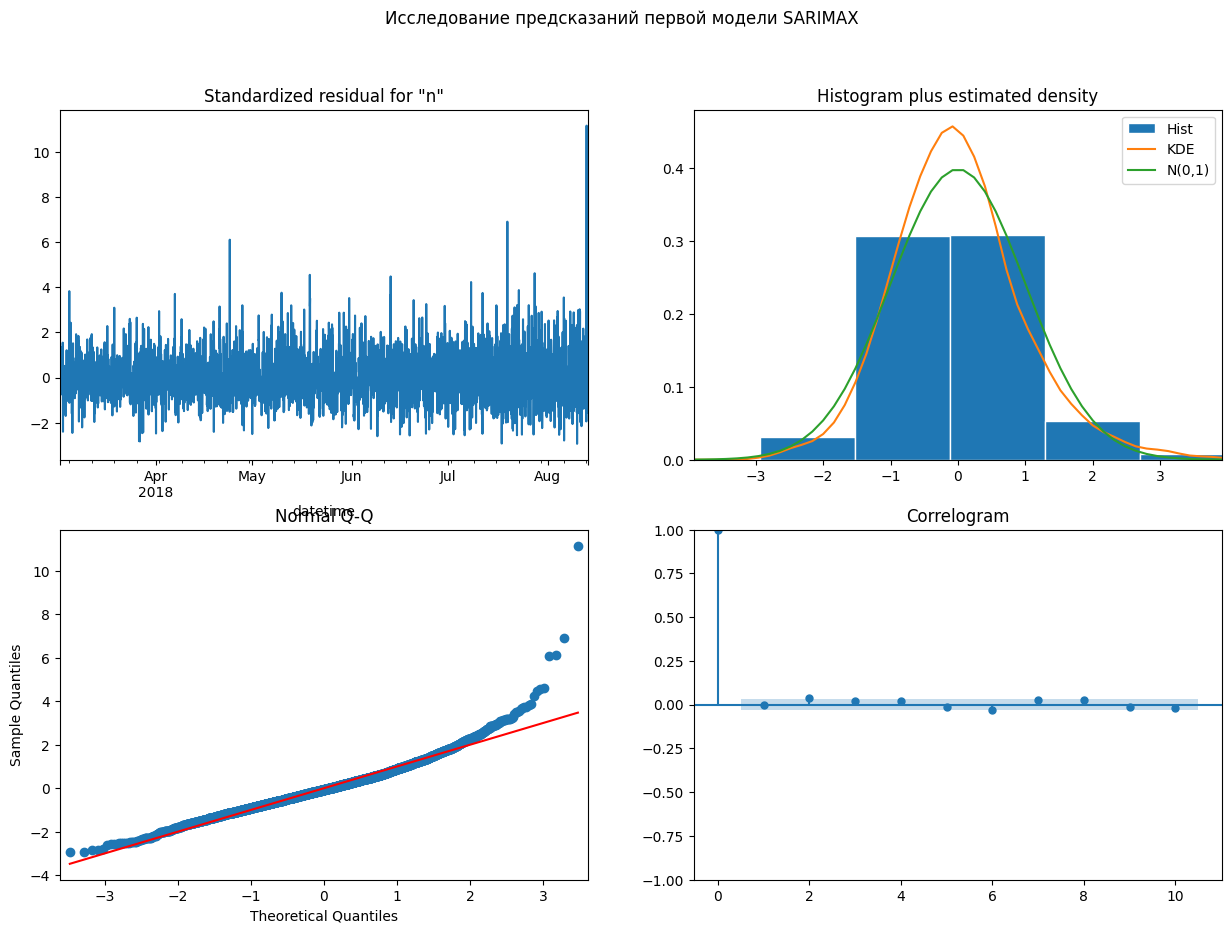

In [40]:
result_1.plot_diagnostics()
plt.suptitle('Исследование предсказаний первой модели SARIMAX')
plt.show()

Заметно, что наша модель в целом неплохо научилась предсказывать большую часть данных, однако (судя по графикам стандартизированных остатков и `QQplot`) модель плохо предсказывает пиковые значения с наибольшим количеством заказов такси

Вспомним, что когда мы строили бейзлайн, модель с лагом 168 показала себя гораздо лучше модели с лагом 24. Проверим это для `SARIMAX`. Обучим `model_2` со значением `p`, равным 7 - для учитывания недельной сезонности

In [41]:
model_2 = SARIMAX(train, 
                  order = (1, 1, 1), 
                  seasonal_order = (7, 1, 1, 24))

result_2 = model_2.fit()

Посмотрим на результат

In [42]:
print(result_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3974
Model:             SARIMAX(1, 1, 1)x(7, 1, 1, 24)   Log Likelihood              -17701.657
Date:                            Sat, 13 Sep 2025   AIC                          35425.314
Time:                                    21:08:50   BIC                          35494.408
Sample:                                03-01-2018   HQIC                         35449.822
                                     - 08-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0326      0.014      2.381      0.017       0.006       0.060
ma.L1         -0.9317      0.006   

Также по столбцу `P>|z|` видим, что все параметры значимы

In [43]:
#тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1
  

predictions_2 = result_2.predict(start, end)
predictions_2

2018-08-13 14:00:00    110.067440
2018-08-13 15:00:00    133.940562
2018-08-13 16:00:00    205.773720
2018-08-13 17:00:00    152.027238
2018-08-13 18:00:00    106.759726
                          ...    
2018-08-31 19:00:00    194.638385
2018-08-31 20:00:00    198.118117
2018-08-31 21:00:00    227.473621
2018-08-31 22:00:00    220.067205
2018-08-31 23:00:00    250.267319
Freq: H, Name: predicted_mean, Length: 442, dtype: float64

In [44]:
print("RMSE на тестовой выборке для SARIMAX и model_2:", root_mean_squared_error(test, predictions_2))

RMSE на тестовой выборке для SARIMAX и model_2: 52.77359151150156


Видим, что на тестовой выборке значение метрики получилось хуже, чем в первом случае.

Посмотрим на графическое отображение работы модели

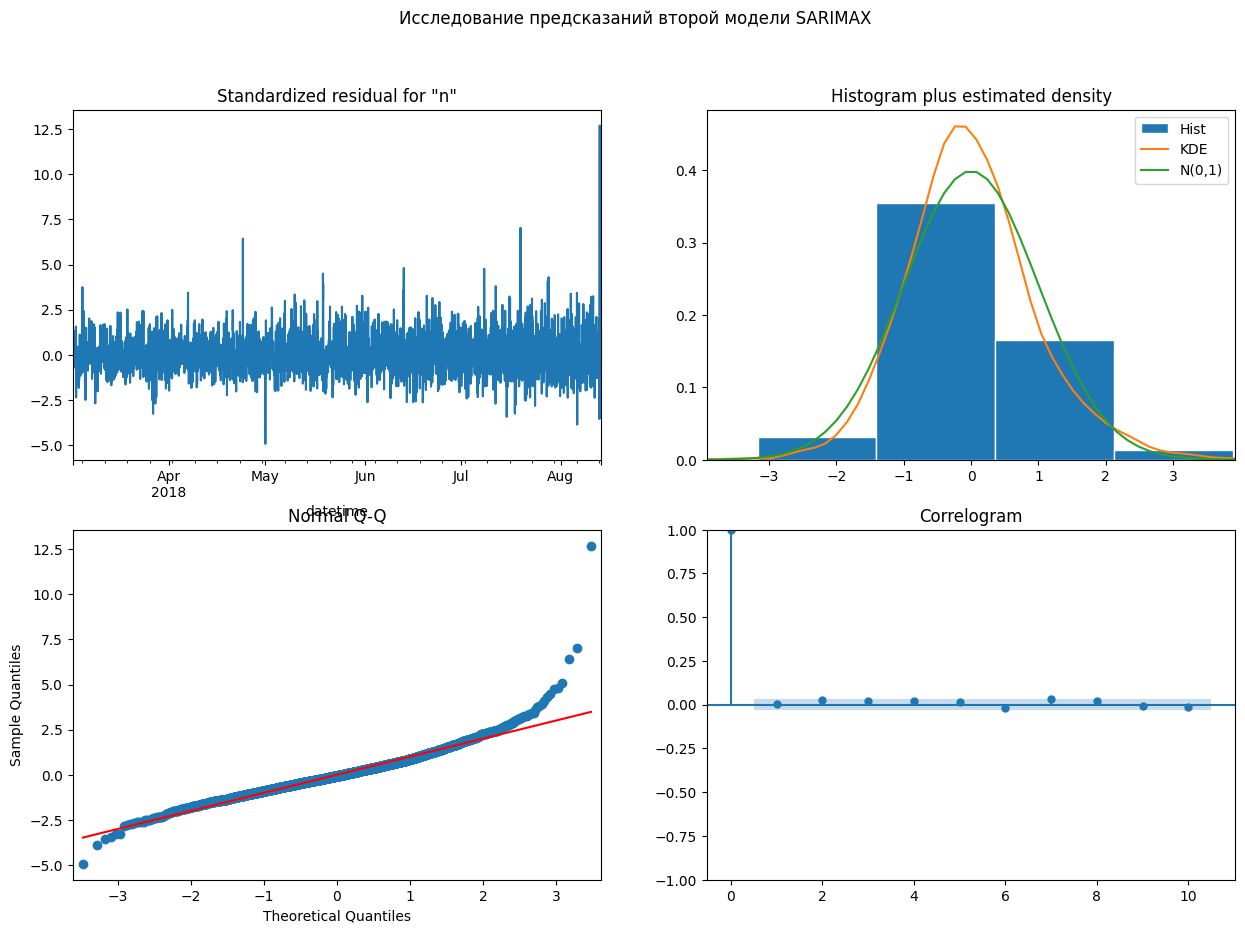

In [45]:
result_2.plot_diagnostics()
plt.suptitle('Исследование предсказаний второй модели SARIMAX')
plt.show()

Заметно, что модель стала хуже предсказывать самые ранние и малые значения - вероятно, сказалось то, что мы взяли слишком большой шаг сезонности

Попробуем учитывать чуть больше предыдущих взаимодействий - возьмём `p`, равное 2 (учтём 2 прошлых значения) и `q`, равное 3 (будем использовать 3 прошлые ошибки прогноза для предсказания)

In [46]:
model_3 = SARIMAX(train, 
                  order = (2, 1, 3), 
                  seasonal_order = (1, 1, 1, 24))

result_3 = model_3.fit()

Посмотрим на результат

In [47]:
print(result_3.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           num_orders   No. Observations:                 3974
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood              -17784.872
Date:                              Sat, 13 Sep 2025   AIC                          35585.744
Time:                                      21:10:33   BIC                          35635.994
Sample:                                  03-01-2018   HQIC                         35603.568
                                       - 08-13-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1048      0.020     -5.172      0.000      -0.144      -0.065
ar.L2          0.88

Также по столбцу `P>|z|` видим, что все параметры значимы

In [48]:
#тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1
  

predictions_3 = result_3.predict(start, end)
predictions_3

2018-08-13 14:00:00    100.458400
2018-08-13 15:00:00    124.186301
2018-08-13 16:00:00    166.978063
2018-08-13 17:00:00    142.899093
2018-08-13 18:00:00     88.052676
                          ...    
2018-08-31 19:00:00    106.876276
2018-08-31 20:00:00    107.550937
2018-08-31 21:00:00    132.384311
2018-08-31 22:00:00    123.663367
2018-08-31 23:00:00    152.339902
Freq: H, Name: predicted_mean, Length: 442, dtype: float64

In [49]:
print("RMSE на тестовой выборке для SARIMAX и model_3:", root_mean_squared_error(test, predictions_3))

RMSE на тестовой выборке для SARIMAX и model_3: 44.674759639857065


Метрика практически равна метрике для первой модели `SARIMAX`

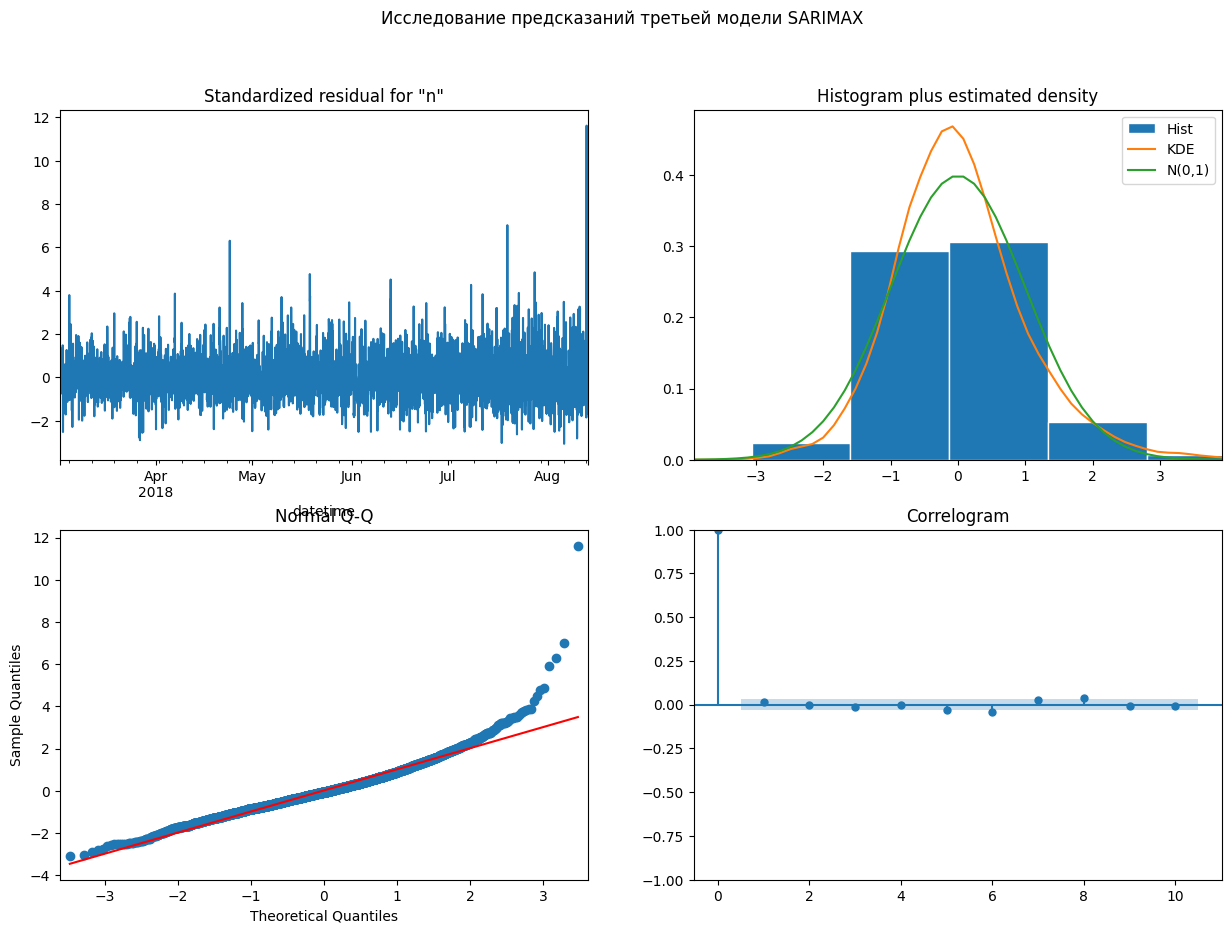

In [50]:
result_3.plot_diagnostics()
plt.suptitle('Исследование предсказаний третьей модели SARIMAX')
plt.show()

Текущая модель очень похожа на первую - большая часть значений предсказывается неплохо, кроме краевых максимальных значений

Таким образом, модель `SARIMAX` позволила нам получить удовлетворяющие требованиям заказчика результаты

### Prophet

Создадим датафрейм для корректной работы `Prophet`

In [51]:
taxi_fb = taxi_copy.reset_index().rename(columns={'datetime': 'ds',
                                                  'num_orders': 'y'}).copy()
taxi_fb.head()

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


Разделим данные на тренировочные и тестовые

In [52]:
train, test = train_test_split(taxi_fb, test_size=0.1, shuffle=False)

print(train.iloc[0, :], '\n')
print(train.iloc[-1, :], '\n')
print(test.iloc[0, :], '\n')
print(test.iloc[-1, :])

ds    2018-03-01 00:00:00
y                     124
Name: 0, dtype: object 

ds    2018-08-13 13:00:00
y                     119
Name: 3973, dtype: object 

ds    2018-08-13 14:00:00
y                     102
Name: 3974, dtype: object 

ds    2018-08-31 23:00:00
y                     205
Name: 4415, dtype: object


Разделение проведено успешно. Установим значение временного интервала, для которого будем получать предсказания

In [53]:
predictions = test.shape[0]
predictions

442

Обучим первую модель на дефолтных параметрах

In [54]:
model_1 = Prophet()
model_1.fit(train)

21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:36 - cmdstanpy - INFO - Chain [1] done processing


Создадим датафрейм с будущими датами для прогноза

In [55]:
future_1 = model_1.make_future_dataframe(periods=predictions, freq='H')
future_1.tail()

,ds
4411,2018-08-31 19:00:00
4412,2018-08-31 20:00:00
4413,2018-08-31 21:00:00
4414,2018-08-31 22:00:00
4415,2018-08-31 23:00:00


Получим прогнозы

In [56]:
forecast_1 = model_1.predict(future_1)
forecast_1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-01 00:00:00,54.621504,55.804060,120.371089,54.621504,54.621504,34.111717,34.111717,34.111717,32.104598,32.104598,32.104598,2.007119,2.007119,2.007119,0.0,0.0,0.0,88.733221
1,2018-03-01 01:00:00,54.627358,59.737711,120.061773,54.627358,54.627358,34.194836,34.194836,34.194836,32.691789,32.691789,32.691789,1.503047,1.503047,1.503047,0.0,0.0,0.0,88.822194
2,2018-03-01 02:00:00,54.633212,54.802720,114.381838,54.633212,54.633212,30.315834,30.315834,30.315834,29.342526,29.342526,29.342526,0.973308,0.973308,0.973308,0.0,0.0,0.0,84.949046
3,2018-03-01 03:00:00,54.639066,38.808570,103.654214,54.639066,54.639066,16.237141,16.237141,16.237141,15.809394,15.809394,15.809394,0.427746,0.427746,0.427746,0.0,0.0,0.0,70.876206
4,2018-03-01 04:00:00,54.644920,15.711748,74.941295,54.644920,54.644920,-9.609317,-9.609317,-9.609317,-9.485730,-9.485730,-9.485730,-0.123587,-0.123587,-0.123587,0.0,0.0,0.0,45.035603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,2018-08-31 19:00:00,125.599153,94.026091,158.590454,125.096969,126.071233,-0.003579,-0.003579,-0.003579,-11.907989,-11.907989,-11.907989,11.904409,11.904409,11.904409,0.0,0.0,0.0,125.595574
4412,2018-08-31 20:00:00,125.622803,100.465485,164.524981,125.118268,126.096599,7.091032,7.091032,7.091032,-4.788438,-4.788438,-4.788438,11.879470,11.879470,11.879470,0.0,0.0,0.0,132.713836
4413,2018-08-31 21:00:00,125.646454,116.004626,178.837387,125.139567,126.121964,21.962091,21.962091,21.962091,10.215500,10.215500,10.215500,11.746592,11.746592,11.746592,0.0,0.0,0.0,147.608545
4414,2018-08-31 22:00:00,125.670104,128.278930,190.893928,125.160866,126.147315,34.920010,34.920010,34.920010,23.414136,23.414136,23.414136,11.505874,11.505874,11.505874,0.0,0.0,0.0,160.590114


Визуализируем предсказания

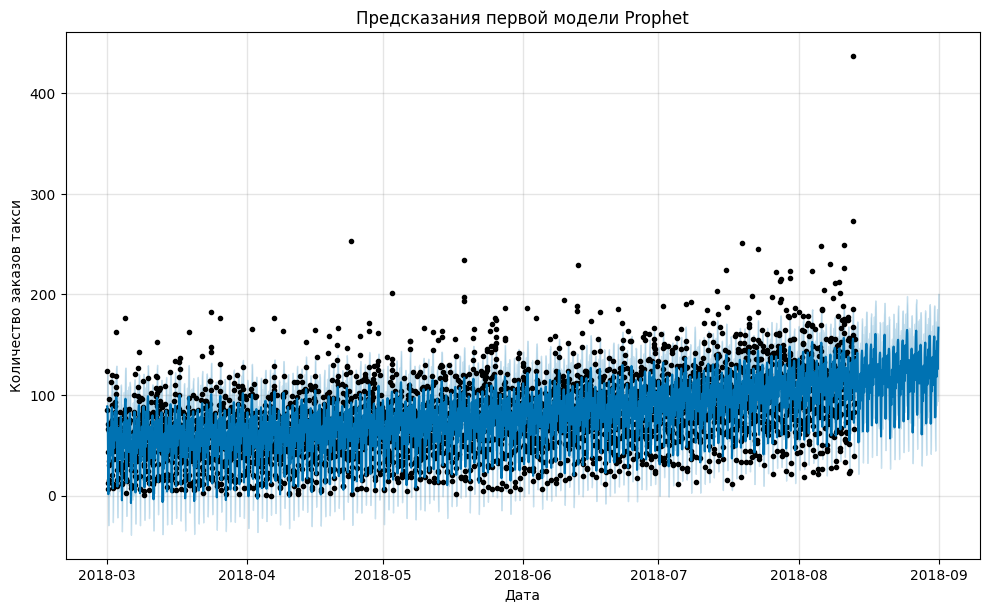

In [57]:
fig1 = model_1.plot(forecast_1)
plt.title('Предсказания первой модели Prophet')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

Как будто модель не очень хорошо уловила возрастание тренда ближе к тестовой выборке

Посмотрим на разложение ряда

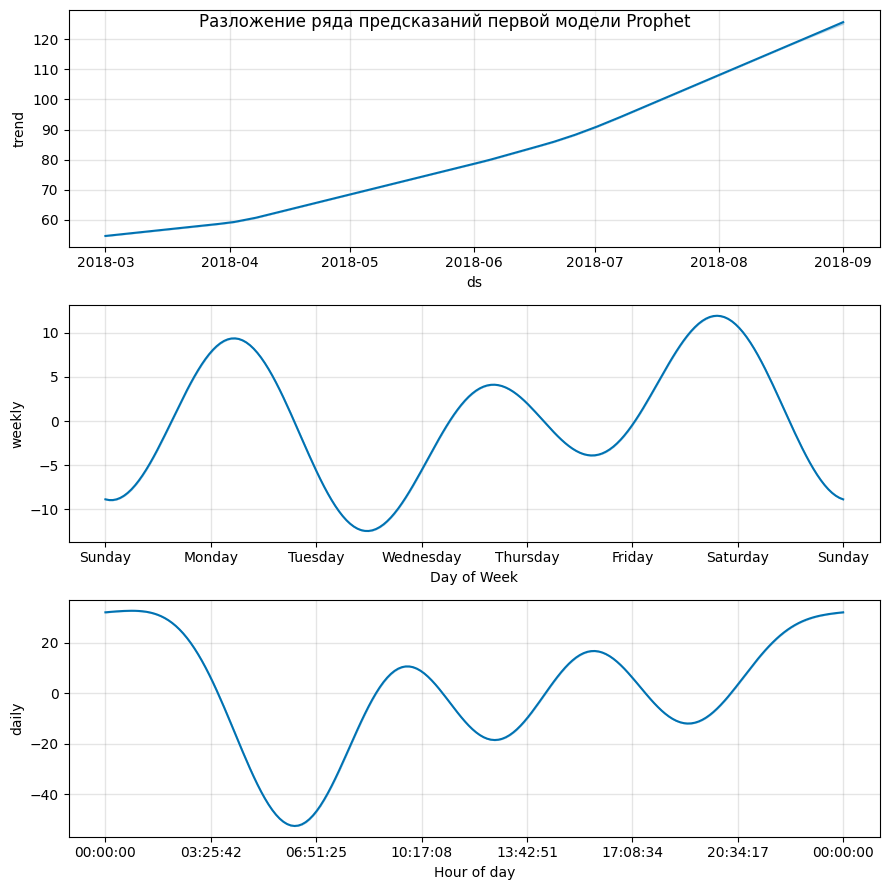

In [58]:
fig2 = model_1.plot_components(forecast_1)
plt.suptitle('Разложение ряда предсказаний первой модели Prophet')
plt.show()

Посмотрим на сравнение предсказанного и фактического временного ряда

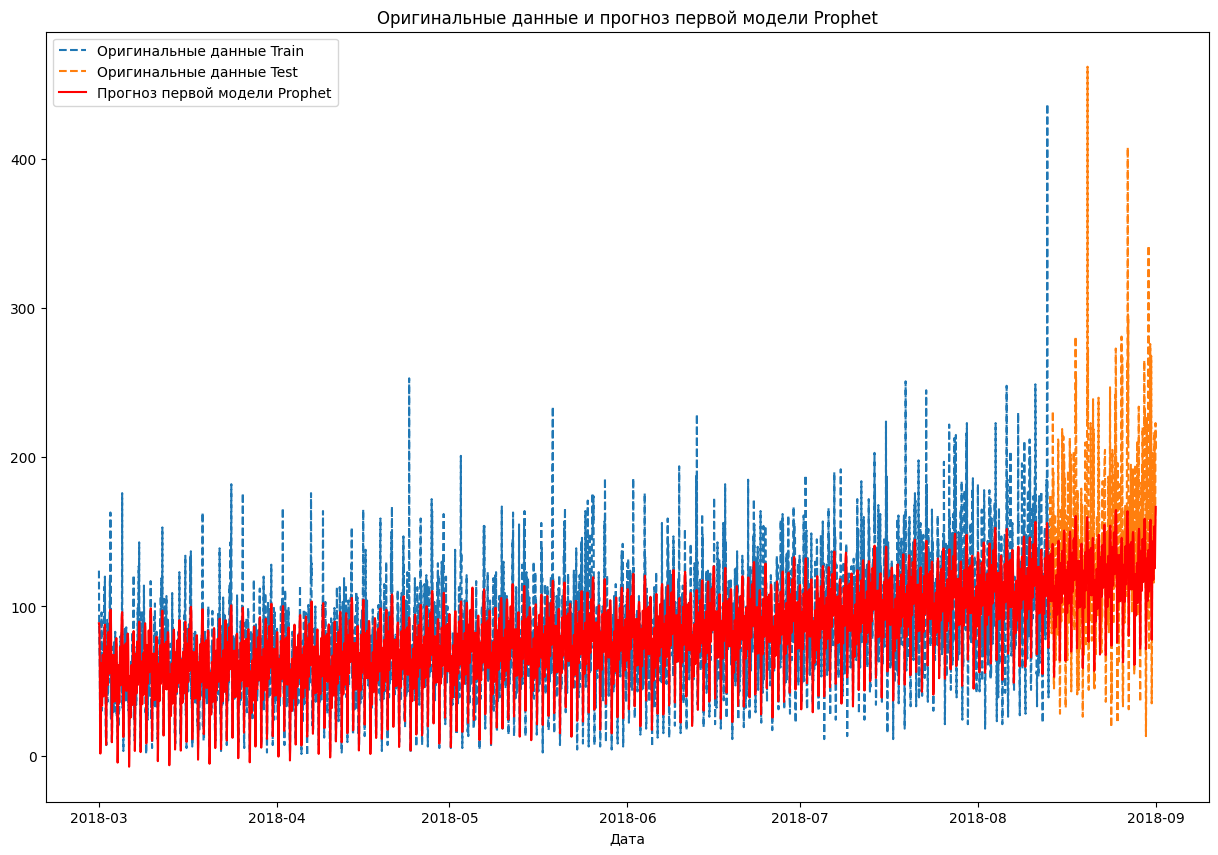

In [59]:
# Оригинальные данные
plt.figure()
plt.plot(train['ds'], train['y'], label='Оригинальные данные Train', linestyle='--')
plt.plot(test['ds'], test['y'], label='Оригинальные данные Test', linestyle='--')

# Прогноз Prophet
plt.plot(forecast_1['ds'], forecast_1['yhat'], label='Прогноз первой модели Prophet', c='red', linestyle='-')

plt.xlabel('Дата')
plt.legend()
plt.title('Оригинальные данные и прогноз первой модели Prophet')
plt.show()

Кажется, что модель не очень уловила тренд.

Получим предсказания для первой модели

In [60]:
# Вычисление RMSE
test_forecast_1 = forecast_1.tail(len(test))
rmse_1 = root_mean_squared_error(test['y'], test_forecast_1['yhat'])
rmse_1

48.24348521749808

Получили пограничное значение, не удовлетворяющее требованиям заказчика

Попробуем усложнить модель:
* `weekly_seasonality=True`: явно отметим недельную сезонность;
* `daily_seasonality=True`: явно отметим суточную сезонность;
* `yearly_seasonality=False`: явно отметим отсутствие годовой сезонности;
* `seasonality_prior_scale=1`: уменьшим регуляризацию сезонности для уменьшения числа ложных колебаний;
* `changepoint_prior_scale=0.2`: повысим подстраиваемость модели под изменения тренда;
* `changepoint_range=1`:  увеличим долю данных для поиска изменений, поскольку ближе к тестовым данным наклон тренда возрастает

Обучим новую модель

In [61]:
model_2 = Prophet(weekly_seasonality=True,
                  daily_seasonality=True,
                  yearly_seasonality=False,
                  seasonality_prior_scale=1,
                  seasonality_mode='multiplicative',
                  changepoint_prior_scale=0.2,
                  changepoint_range=1)

model_2.fit(train)

21:10:39 - cmdstanpy - INFO - Chain [1] start processing
21:10:40 - cmdstanpy - INFO - Chain [1] done processing


Далее повторим шаги для первой модели

In [62]:
# Создаём DataFrame с будущими датами для прогноза
future_2 = model_2.make_future_dataframe(periods=predictions, freq='H')
future_2.tail()

,ds
4411,2018-08-31 19:00:00
4412,2018-08-31 20:00:00
4413,2018-08-31 21:00:00
4414,2018-08-31 22:00:00
4415,2018-08-31 23:00:00


In [63]:
# Прогнозируем
forecast_2 = model_2.predict(future_2)
forecast_2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2018-03-01 00:00:00,55.520850,47.742955,112.163848,55.520850,55.520850,0.397252,0.397252,0.397252,0.419294,0.419294,0.419294,0.022042,0.022042,0.022042,0.0,0.0,0.0,78.800436
1,2018-03-01 01:00:00,55.528288,48.709447,112.342051,55.528288,55.528288,0.419620,0.419620,0.419620,0.435041,0.435041,0.435041,0.015421,0.015421,0.015421,0.0,0.0,0.0,79.685358
2,2018-03-01 02:00:00,55.535727,45.864885,111.068145,55.535727,55.535727,0.394059,0.394059,0.394059,0.402560,0.402560,0.402560,0.008501,0.008501,0.008501,0.0,0.0,0.0,77.892209
3,2018-03-01 03:00:00,55.543165,36.400745,97.423928,55.543165,55.543165,0.235017,0.235017,0.235017,0.236425,0.236425,0.236425,0.001408,0.001408,0.001408,0.0,0.0,0.0,68.674967
4,2018-03-01 04:00:00,55.550603,19.753209,81.838451,55.550603,55.550603,-0.083345,-0.083345,-0.083345,-0.089077,-0.089077,-0.089077,-0.005732,-0.005732,-0.005732,0.0,0.0,0.0,50.602331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,2018-08-31 19:00:00,170.009254,134.847451,199.696471,159.271829,179.802898,-0.165306,-0.165306,-0.165306,-0.016239,-0.016239,-0.016239,0.149067,0.149067,0.149067,0.0,0.0,0.0,167.248414
4412,2018-08-31 20:00:00,170.113897,148.501922,216.344863,159.323739,179.944062,-0.081452,-0.081452,-0.081452,0.067386,0.067386,0.067386,0.148838,0.148838,0.148838,0.0,0.0,0.0,181.577191
4413,2018-08-31 21:00:00,170.218541,177.899528,246.689265,159.385964,180.078391,0.105514,0.105514,0.105514,0.252756,0.252756,0.252756,0.147243,0.147243,0.147243,0.0,0.0,0.0,213.242350
4414,2018-08-31 22:00:00,170.323184,206.410915,277.646729,159.447923,180.217562,0.273096,0.273096,0.273096,0.417378,0.417378,0.417378,0.144282,0.144282,0.144282,0.0,0.0,0.0,241.412339


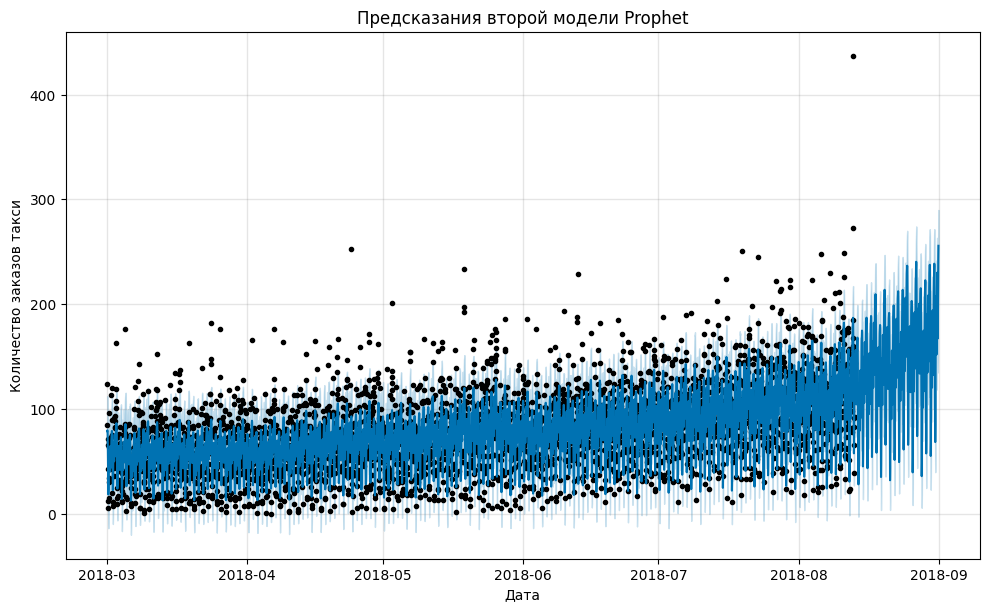

In [64]:
# Визуализация
fig3 = model_2.plot(forecast_2)
plt.title('Предсказания второй модели Prophet')
plt.xlabel('Дата')
plt.ylabel('Количество заказов такси')
plt.show()

Визуально выглядит лучше первой модели, как будто модель стала лучше угадывать закономерности тренда вблизи тестовых данных

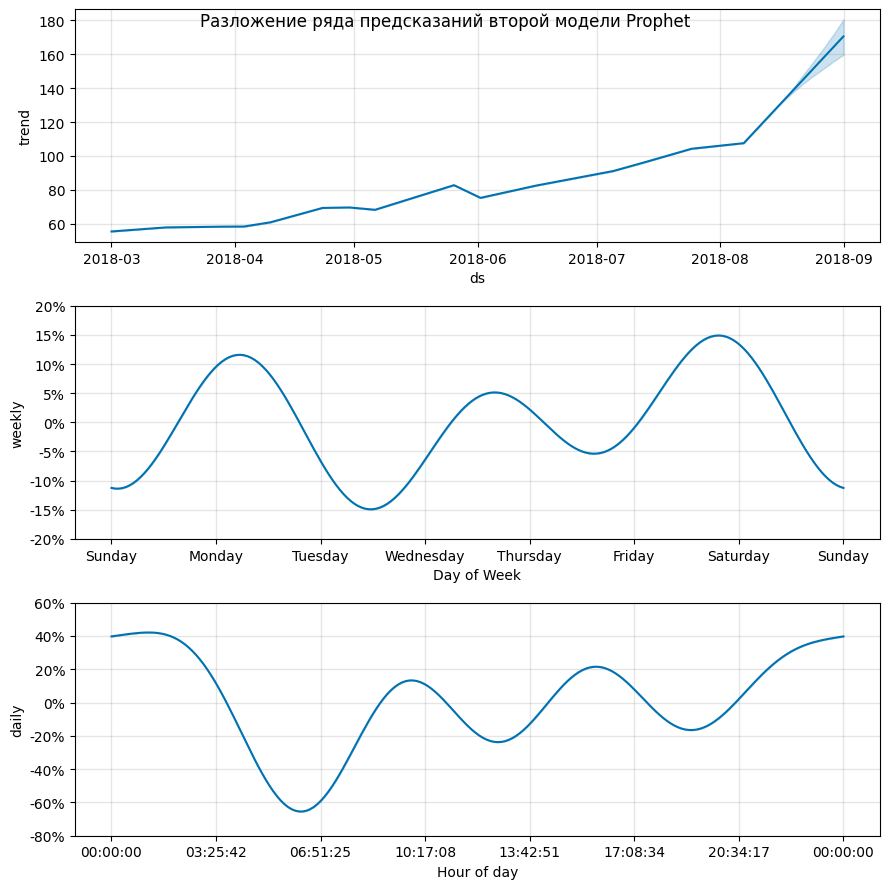

In [65]:
#разложение ряда
fig4 = model_2.plot_components(forecast_2)
plt.suptitle('Разложение ряда предсказаний второй модели Prophet')
plt.show()

Тренд стал более изменчивым

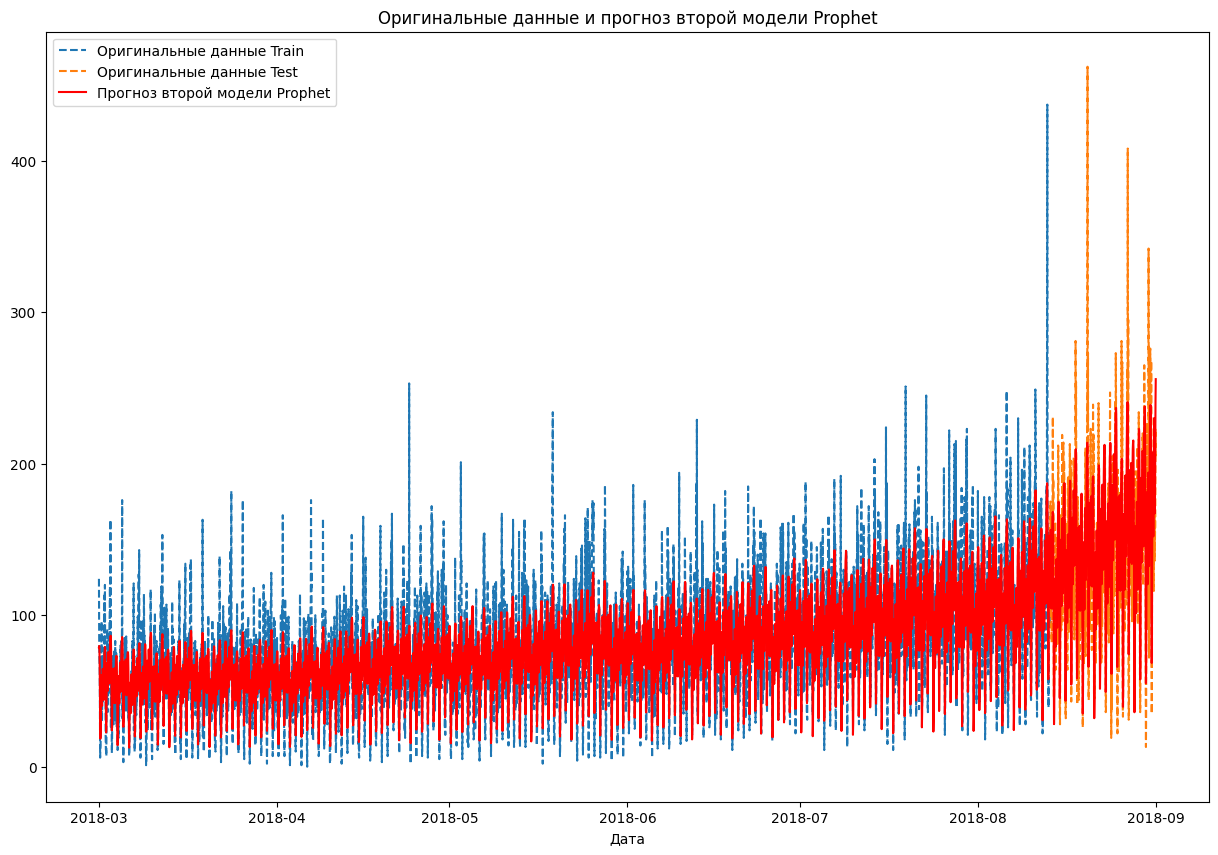

In [66]:
# Оригинальные данные
plt.figure()
plt.plot(train['ds'], train['y'], label='Оригинальные данные Train', linestyle='--')
plt.plot(test['ds'], test['y'], label='Оригинальные данные Test', linestyle='--')

# Прогноз Prophet
plt.plot(forecast_2['ds'], forecast_2['yhat'], label='Прогноз второй модели Prophet', c='red', linestyle='-')

plt.xlabel('Дата')
plt.legend()
plt.title('Оригинальные данные и прогноз второй модели Prophet')
plt.show()

Визуально модель действительно стала лучше предсказывать таргет. Посмотрим, как это сказалось на метрике

In [67]:
# Вычисление RMSE
test_forecast_2 = forecast_2.tail(len(test))
rmse_2 = root_mean_squared_error(test['y'], test_forecast_2['yhat'])
rmse_2

40.2145999209822

Качество модели значительно улучшилось и практически сравнялось с качеством предсказаний бейзлайна. 

### Linear Regression

Посмотрим ещё раз на данные

In [68]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Создадим функцию для генерации признаков разных типов. Не забудем устранить утечку таргета

In [69]:
def make_features(data, max_lag, rolling_mean_size):
    
    #создание календарных признаков
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    #создание признаков на основе лагов
    for i in range(1, max_lag + 1):
        data[f'lag_{i}'] = data['num_orders'].shift(i)
    
    #создание признака на основе скользящего среднего
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size,
                                                      closed='left').mean()


make_features(taxi, 168, 168)

In [70]:
taxi.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Новые признаки успешно созданы. Разобьём данные на тренировочную и тестовую выборку, удалим пропущенные значения

In [71]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2018-03-08 00:00:00', freq='H'),
 Timestamp('2018-08-13 13:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Данные успешно разделены на тренировочные и тестовые. Выделим признаковое описание и таргет

In [72]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

Обучим модель линейной регрессии

In [73]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [74]:
print('RMSE для тренировочной выборки:', root_mean_squared_error(y_train, model_lr.predict(X_train)))
print('RMSE для тестовой выборки:', root_mean_squared_error(y_test, model_lr.predict(X_test)))

RMSE для тренировочной выборки: 20.36137910818501
RMSE для тестовой выборки: 34.52644611115775


Хоть мы и получили снижение метрики на тесте по сравнению с тренировочными данными практически в 2 раза (ввиду вышеописанных причин, в частности, из-за роста доли остатков временного ряда), линейная регрессия показала наилучшие результаты на тестовых данных среди всех способов предсказания таргета - `RMSE` равна 34.53. Вероятно, это обусловлено малым изменением тренда, что мы наблюдали на различных графиках нашего временного ряда, а также тем, что `Prophet` и `SARIMAX` предсказывают сразу весь временной интервал тестовой выборки

Таким образом, в данном разделе было проведено обучение моделей и получение предсказаний на тестовых данных:
* использование предсказаний таргета лагом 168 в качестве бейзлайна позволило получить значение `RMSE` 39.55 - недельная сезонность помогла получить хорошие предсказания даже без использования машинного обучения. При этом получение предсказаний на основе суточной сезонности не позволило достичь требуемого заказчиком значения метрик;
* использование `SARIMAX` позволило нам получить удовлетворяющие требованиям заказчика результаты (`RMSE` 44.46);
* использование `Prophet` c подбором гиперпараметров под конкретные данные позволило достичь значения метрики `RMSE` 40.21;
* наилучшие результаты показала модель линейной регрессии с метрикой `RMSE` на тестовых данных, равной 34.53;
* все четыре способа предсказания таргета удовлетворяют требованиям заказчика.

## Итоговые выводы

**Ход исследования:**

* *загрузка данных*

Необходимые библиотеки были импортированы, данные загружены, названия столбцов соответствовали стандартам.

* *предобработка данных*

В данном разделе была проведена базовая предобработка данных. Отмечено отсутствие пропущенных значений и полных дубликатов. Проведена переиндексация датафрейма на основе признака `datetime`, для которого предварительно изменён тип данных на `datetime64`. Полученный индекс нарастает монотонно. Анализ базовых статистик признака `num_orders` не выявил аномалий.

* *исследовательский анализ данных*

В данном разделе был проведён исследовательский анализ данных:

* проведено ресэмплирование исходных данных по одному часу;
* по тесту Дики-Фуллера была отвергнута нулевая гипотеза, что наш исходный ряд является нестационарным;
* установлено, что в нашем ряду присутствует тренд, устраняемый лагом 1;
* установлено, что в нашем ряду присутствует суточная и недельная сезонность;
* отмечено, что использование скользящего среднего с окнами, равными 24 и 168 - суточная и недельная сезонность - приводит к существенному сглаживанию данных;
* установлено, что в последних двух месяцах наблюдается увеличение доли остатков, что может привести к некоторому ухудшению предсказательной способности моделей на тестовых данных;
* найдено, что в распределении таргета присутствует смещение вправо из-за пуассоновского распределения значений


* *Обучение моделей и получение предсказаний*

В данном разделе было проведено обучение моделей и получение предсказаний на тестовых данных:

* Наилучшие результаты показала модель линейной регрессии с метрикой `RMSE` на тестовых данных, равной 34.53. Вероятно, это обусловлено малым изменением тренда и большой важностью созданных нами на основе сезонностей признаков;
* Предсказание значений целевой переменной лагом 168 в качестве бейзлайна привело к значению `RMSE` 39.55 - недельная сезонность помогла получить хорошие предсказания даже без использования машинного обучения. При этом получение предсказаний на основе суточной сезонности (лаг 24) не позволило достичь требуемого заказчиком значения метрики;
* использование `Prophet` c подбором гиперпараметров под конкретные данные (учёт сезонности, изменчивости тренда вблизи тестовых данных) позволило достичь значения метрики `RMSE` 40.21;
* использование `SARIMAX` позволило нам также получить удовлетворяющие требованиям заказчика результаты (`RMSE` 44.46)